
# A Life Cycle Model: Data and Theory

National registry data on income and wealth from Scandinavian countries (esp. Norway) have recently become available (with a lot of security) to some (lucky!) researchers.   These data offer a uniquely powerful tool for testing (and improving) our models of consumption and saving behavior over the life cycle.

This notebook is an example of how to construct a life cycle model with the HARK toolkit that makes predictions that can be compared to the raw data statistics that now are becoming available.

For example, existing papers have tabulated information about the **growth rate** of assets at different ages over the life cycle. 

The default parameters of the HARK life cycle model have not been optmized to match features of the Norwegian data; a first step in a real "structural" estimation would be to use Norwegian calibrate the inputs to the model (like the profile of income, and the magnitude of income shocks, over the life cycle), and then to find the values of parameters like the time preference rate that allow the model to fit the data best.  (See [SolvingMicroDSOPs](https://econ.jhu.edu/people/ccarroll/SolvingMicroDSOPs) for how this can be done, and search for the corresponding HARK content using [our documentation](https://hark.readthedocs.io)).

In [1]:
# Initial imports and notebook setup, click arrow to show

import HARK.ConsumptionSaving.ConsIndShockModel as cShksModl        # The consumption-saving micro model
import HARK.SolvingMicroDSOPs.Calibration.EstimationParameters as Params    # Parameters for the consumer type and the estimation
from HARK.utilities import plotFuncsDer, plotFuncs              # Some tools

import numpy as np

***NOTE: using a 'quick fix' for an attribute error. See 'Error Notes' in EstimationParameter.py for further discussion.***


In [2]:
# Set up default values for CRRA, DiscFac, and simulation variables in the dictionary 
Params.init_consumer_objects["CRRA"]= 2.00            # Default coefficient of relative risk aversion (rho)
Params.init_consumer_objects["DiscFac"]= 0.97         # Default intertemporal discount factor (beta)
Params.init_consumer_objects["PermGroFacAgg"]= 1.0    # Aggregate permanent income growth factor 
Params.init_consumer_objects["aNrmInitMean"]= -10.0   # Mean of log initial assets 
Params.init_consumer_objects["aNrmInitStd"]= 1.0      # Standard deviation of log initial assets
Params.init_consumer_objects["pLvlInitMean"]= 0.0     # Mean of log initial permanent income 
Params.init_consumer_objects["pLvlInitStd"]= 0.0      # Standard deviation of log initial permanent income

In [3]:
# Make an instance of a lifecycle consumer to be used for estimation
LifeCyclePop = cShksModl.IndShockConsumerType(**Params.init_consumer_objects)

In [4]:
# Solve and simulate the model (ignore the "warning" message)
LifeCyclePop.solve()                            # Obtain consumption rules by age 
LifeCyclePop.unpackcFunc()                      # Expose the consumption rules

# Which variables do we want to track
LifeCyclePop.track_vars = ['aNrmNow','pLvlNow','mNrmNow','cNrmNow','TranShkNow']

LifeCyclePop.T_sim = 120                        # Nobody lives to be older than 145 years (=25+120)
LifeCyclePop.initializeSim()                    # Construct the age-25 distribution of income and assets
LifeCyclePop.simulate()                         # Simulate a population behaving according to this model

C:\Users\taaur\Anaconda3\lib\site-packages\HARK\interpolation.py:1710: RuntimeWarning: All-NaN slice encountered
  y = np.nanmin(fx,axis=1)


Consumption as a function of market resources while working:


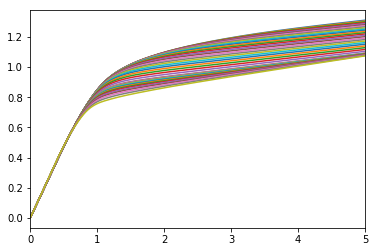

In [5]:
# Plot the consumption functions during working life

print('Consumption as a function of market resources while working:')
mMin = min([LifeCyclePop.solution[t].mNrmMin for t in range(LifeCyclePop.T_cycle)])
plotFuncs(LifeCyclePop.cFunc[:LifeCyclePop.T_retire],mMin,5)

In [8]:
# Define the saving rate function
def savRteFunc(SomeType, m):
    """
    Parameters:
    ----------
        SomeType: 
             Agent type that has been solved and simulated.
        
        
    Returns:
    --------
        savRte: float
    
    """
    inc = (SomeType.Rfree -1.)*(m-1.)+1. # Normalized by permanent labor income
    cns = SomeType.solution[0].cFunc(m)  # Consumption (normalized)
    sav = inc - cns                      # Flow of saving this period
    savRte = sav / inc                   # Saving Rate
    return savRte

In [11]:
# Create a giant matrix gathering useful data:
# 't_now', 'aNrmNow_hist', 'cNrmNow_hist', employment-status in date t and date t-1,
# aLvlGro_hist, Saving rate

w, h = 1, LifeCyclePop.T_cycle
giant_list = [[0 for x in range(w)] for y in range(h)]
savRte_list = []

import warnings
warnings.filterwarnings("ignore") # Suppress some disturbing but harmless warnings

for t in range(1,LifeCyclePop.T_cycle+1):
    #aLvlGro_hist[0] = 0 # set the first growth rate to 0, since there is no data for period 0
    aLvlGroNow = np.log((LifeCyclePop.aNrmNow_hist[t]   *LifeCyclePop.pLvlNow_hist[t])/ \
                         LifeCyclePop.aNrmNow_hist[t-1] *LifeCyclePop.pLvlNow_hist[t-1]) # (10000,)

    # Call the saving rate function defined above 
    savRte = savRteFunc(LifeCyclePop, LifeCyclePop.mNrmNow_hist[t] )
    savRte_list.append(savRte) # Add this period's saving rate to the list 

    # Create elements of matrix list
    matrix_list = [0 for number in range(7)]
    matrix_list[0] = t
    matrix_list[1] = LifeCyclePop.aNrmNow_hist[t]
    matrix_list[2] = LifeCyclePop.cNrmNow_hist[t]
    matrix_list[3] = LifeCyclePop.TranShkNow_hist[t]
    matrix_list[4] = LifeCyclePop.TranShkNow_hist[t-1]
    matrix_list[5] = aLvlGroNow
    matrix_list[6] = savRte
    
    giant_list[t-1] = matrix_list

In [12]:
# Construct the level of assets A from a*p where a is the ratio to permanent income p
# Remember 41 is "years after entering workforce" (=age 25); 66 is the year right after retirement
LifeCyclePop.aLvlNow_hist = LifeCyclePop.aNrmNow_hist*LifeCyclePop.pLvlNow_hist
aGro41=LifeCyclePop.aLvlNow_hist[41]/LifeCyclePop.aLvlNow_hist[40]
aGro41NoU=aGro41[aGro41[:]>0.2] # Throw out extreme outliers; don't want growth rates relative to 0 income!

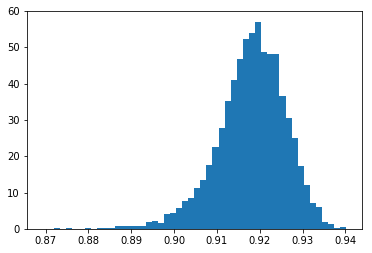

In [13]:
# Plot the (truncated) distribution of growth rates of wealth between age 65 and 66 (=25 + 41)
from matplotlib import pyplot as plt
n, bins, patches = plt.hist(aGro41NoU,50,density=True)

In [ ]:
n, bins, patches = plt.hist(LifeCyclePop.TranShkNow_hist, 50, density=True)

# PROBLEM : Distribution of aNrm and aLev

Perhaps more interesting than the distribution of asset growth rates over the life cycle is the distribution of the level of assets, or the ratio of assets to permanent income.

Construct a plot similar to the one above for the disributions of $\texttt{aNrm}$ and $\texttt{aLev}$ in the period just BEFORE retirement (44 periods from the start).


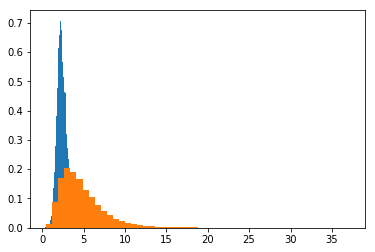

In [62]:
# COMMENT: if retirement is at age 65 (66 being the year right after retirement), then age 64 is the year just
#          before retirement. Wouldn't that correspond to period 39 after the start? I.e. two periods before age
#          66 which is the year after retirement.

aNrm39 = LifeCyclePop.aNrmNow_hist[39]
aLvl39 = aNrm39*LifeCyclePop.pLvlNow_hist[39]

n, bins, patches = plt.hist(aNrm39, 50, density=True)
n, bins, patches = plt.hist(aLvl39, 50, density=True)

# PROBLEM : "Luck" and Saving

In this model, each consumer experiences a set of draws of permanent income shocks over their lifetime.  Some will be lucky and draw a mostly positive series of shocks (and unlucky people experience negative shocks).

This problem asks you to examine the consequences of these shocks for the lifetime pattern of saving.

The first step is to recalibrate the model so that there is no difference in initial assets, then reconstruct the initial conditions and simulate the model:

In [36]:
# Just update the relevant parameter and create a new object with otherwise similar properties.
Params.init_consumer_objects["aNrmInitStd"]= 0.0      # Standard deviation of log initial assets
LifeCyclePop2 = cShksModl.IndShockConsumerType(**Params.init_consumer_objects)

# Solve and simulate the model (ignore the "warning" message)
LifeCyclePop2.solve()                            # Obtain consumption rules by age 
LifeCyclePop2.unpackcFunc()                      # Expose the consumption rules

# Which variables do we want to track
LifeCyclePop2.track_vars = ['aNrmNow','pLvlNow','mNrmNow','cNrmNow','TranShkNow']

LifeCyclePop2.T_sim = 120                        # Nobody lives to be older than 145 years (=25+120)
LifeCyclePop2.initializeSim()                    # Construct the age-25 distribution of income and assets
LifeCyclePop2.simulate()                         # Simulate a population behaving according to this model

# PROBLEM : "Luck" and Saving (cont)

Now we are interested in comparing the people who were "lucky" vs those who were "unlucky"

The easiest way to measure this is by the cumulated level of noncapital (labor) income they have experienced over their working life.

For consumer in period 41 (age 66), calculate this object, then plot it against the $\texttt{aNrm}$ ratio at age 66.

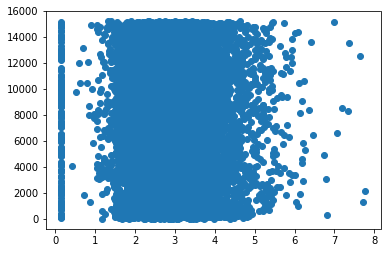

In [73]:
# Doesn't "work": non-sensical results.
#mNrm = LifeCyclePop2.mNrmNow_hist
#incNrm = (LifeCyclePop2.Rfree -1.)*(mNrm-1.) + 1
#incLvl = incNrm*LifeCyclePop2.pLvlNow_hist
#cumIncLvl = np.cumsum(incLvl, axis = 1)
#cumIncLvl41 = cumIncLvl[41]
#
#aNrm41 = LifeCyclePop2.aNrmNow_hist[41]
#
#
#n, bins, patches = plt.hist(cumIncLvl41)
#n, bins, patches = plt.hist(aNrm41)
#
#plt.scatter(aNrm41, cumIncLvl41)

#  Second attempt: gives the same results =/
LifeCyclePop2.incNrm_hist = LifeCyclePop2.TranShkNow_hist
LifeCyclePop2.incLvl_hist = LifeCyclePop2.incNrm_hist*LifeCyclePop2.pLvlNow_hist
LifeCyclePop2.cumIncLvl_hist = np.cumsum(LifeCyclePop2.incLvl_hist, axis = 1)
cumIncLvl41 = LifeCyclePop2.cumIncLvl_hist[41]
aNrm41 = LifeCyclePop2.aNrmNow_hist[41]

plt.scatter(aNrm41, cumIncLvl41)

# PROBLEM : "Luck" and Saving (cont)

You can have luck in transitory income shocks or in permanent income shocks.  Their consequences are quite different.  With a permanent shock, you expect your (noncapital) income to change forever, and (according to Friedman (1957)) you should adjust your consumption nearly one-for-one.  With a transitory shock, you expect your income to return to its "permanent" level so you do not consume. So if you get a positive transitory shock, you will mostly save it.

The existence of transitory shocks therefore means that people who have on average experienced positive transitory shocks over their lifetimes should have higher saving rates.  That would bias the relationship between lifetime income and the $\texttt{aNrm}$ ratio upward.

To see how important this might be, redo the same exercise as before, but using the level of (noncapital) permanent income (rather than overall income including transitory and permanent) over the lifetime

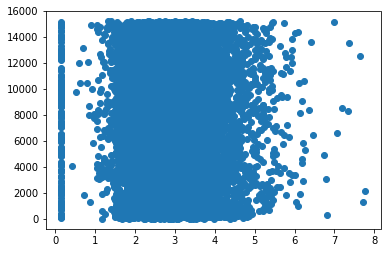

In [74]:
cumPincLvl = np.cumsum(LifeCyclePop2.pLvlNow_hist, axis=1)
cumPincLvl41 = cumPincLvl[41]

plt.scatter(aNrm41, cumPincLvl41)

# PROBLEM : Saving Rates and Wealth Levels

The Haig-Simons definition of "saving" is basically the amount by which your wealth changes from one period to the next. This definition includes the consequences of any capital gains (or losses) for your wealth.  

In recent work, Faegering, Holm, Natvik, and Moll have proposed that instead households largely ignore the consequences of capital gains and losses.  That is, their consumption is largely unchanged by asset price movements.

Specifically, they define "active saving" as the difference between income and consumption _neglecting_ any contriubutions from "buy and hold" assets like houses or stocks.  The "active saving rate" is the quantity of active saving divided by the level of income. They find that the "active saving rate" is remarkably stable over the range from roughly the 20th percentile to the 95th percentile of the wealth distribution.

The basic model considered above does not allow for capital gains or losses, so it can be used to calculate directly the saving behavior of people who do not anticipate capital gains and losses.  So, the saving rate computed by the $\texttt{savRte}$ function above should correspond to their "active saving rate."

Your problem is, for the entire population simulated above, to calculate what this predicts about the saving rate they measure.  You will do this by grouping the population into vigntile bins, and calculating the average active saving rate for all the households in each vigntile, and then plotting the wealth vigntiles against their saving rates.


In [ ]:
# put your solution here